In [1]:
suppressPackageStartupMessages({
    require(igraph)
    library(dplyr)
    library(ggvenn)
    library(tidyr)
    library(ggpubr)
    library(rstatix)
    library(stringr)
})

In [2]:
markers <- readRDS('/mnt/data01/yuanzhen/01.Vertebrate_cell_evo/01.data/03.markers/allmarkers.wilcox.FDR001_FC1.5.rds')

In [3]:
# expressed genes for each species at cell type family level
#markers <- readRDS('exp_domain/combined.exp_tri_score.rds')

In [4]:
Amniote_homologous_celltypes <- read.delim('/mnt/data01/yuanzhen/01.Vertebrate_cell_evo/01.data/02.atlas_final/3.plotting/8.plot_dotplot_cross_species/celltype_ordering.v2.txt', header = F)$V1
Vertebrate_homologous_celltypes <- Amniote_homologous_celltypes[!Amniote_homologous_celltypes %in% 
                                                                c('Oligodendrocyte precursor cells','Oligodendrocytes')]

In [5]:
duplicate_pairs <- readRDS("Combined.SSD_WGD.rds")

In [6]:
orthogroups <- read.delim('/mnt/data01/yuanzhen/01.Vertebrate_cell_evo/02.gene_relationships/run4/results/Ortho_pipeline/OrthoFinder/Orthogroups/Orthogroups.tsv')
# at least one copy for 4 species
orthogroups <- orthogroups %>% select(c('Orthogroup', 'Pmar', 'Pvit', 'Mmus', 'Hsap'))  %>% 
    filter(Pmar != '' & Pvit != '' & Mmus != '' & Hsap != '')

In [7]:
# calculate number of genes by calcualting commas in it
count_commas <- function(x) {
  sapply(gregexpr(",", x), function(match) ifelse(match[1] == -1, 0, length(match)))
}
number_genes <- data.frame(apply(orthogroups, c(1,2), count_commas))

# retain orthogroups with only 5 copies max for each four species
orthogroups <- orthogroups[which(number_genes$Pmar <= 4 & number_genes$Pvit <= 4 & number_genes$Mmus <= 4 & number_genes$Hsap <= 4), ]

In [8]:
WGD_genes <- unique(c(duplicate_pairs[duplicate_pairs$type == 'WGD', 'dup1'], duplicate_pairs[duplicate_pairs$type == 'WGD', 'dup2']))
SSD_genes <- unique(c(duplicate_pairs[duplicate_pairs$type == 'SSD', 'dup1'], duplicate_pairs[duplicate_pairs$type == 'SSD', 'dup2']))
paralog_genes <- unique(c(duplicate_pairs[,'dup1'], duplicate_pairs[,'dup2']))

# pay attention! at least a pair (since it's in the same gene family:orthogroup)
# a pair of ohnologues or SSD paralogues
WGD_orthogroups <- orthogroups[apply(orthogroups, 1, function(row) {
  any(sapply(row, function(cell) {
    sum(WGD_genes %in% unlist(strsplit(as.character(cell), ", "))) >= 2
  }))
}), ]

SSD_orthogroups <- orthogroups[apply(orthogroups, 1, function(row) {
  any(sapply(row, function(cell) {
    sum(SSD_genes %in% unlist(strsplit(as.character(cell), ", "))) >= 2
  }))
}), ]

Paralog_orthogroups <- orthogroups[apply(orthogroups, 1, function(row) {
  any(sapply(row, function(cell) {
    sum(paralog_genes %in% unlist(strsplit(as.character(cell), ", "))) >= 2
  }))
}), ]


In [9]:
#check the number of orthogroups being classified as both WGD_orthogroups and SSD_orthogroups
shared <- semi_join(WGD_orthogroups, SSD_orthogroups, by = colnames(SSD_orthogroups))
dim(shared)

[1] 1655    5

In [10]:
get_gene_ID <- function(row, species){
    return(paste(species, unlist(strsplit(as.character(row[[species]]), ", ")), sep = '_'))
}

In [11]:
# for only amniotes
get_results_amniotes <- function(orthogroup){
    results <- Reduce(rbind, apply(orthogroup, 1, FUN = function(row){
        # get gene IDs for each species
        Hsap = get_gene_ID(row, 'Hsap')
        Mmus = get_gene_ID(row, 'Mmus')
        Pvit = get_gene_ID(row, 'Pvit')
        # construct exp matrix
        mtx1 = data.frame(matrix(0, nrow = length(c(Hsap, Mmus, Pvit)), ncol = length(Amniote_homologous_celltypes)))
        rownames(mtx1) <- c(Hsap, Mmus, Pvit)
        colnames(mtx1) <- Amniote_homologous_celltypes
        # use markers to binarize mtx
        for (g in rownames(mtx1)){
            c <- markers[match(g, markers$species_gene), "cluster"]
            if (!is.na(c)){
                mtx1[g, colnames(mtx1) %in% c] <- 1   
            }
        }

        Hsap_tmp <- colSums(mtx1[grepl('Hsap', rownames(mtx1)),])
        Mmus_tmp <- colSums(mtx1[grepl('Mmus', rownames(mtx1)),])
        Pvit_tmp <- colSums(mtx1[grepl('Pvit', rownames(mtx1)),])
        Ancestral_states1 <- ifelse( 
            (Hsap_tmp > 0 & Mmus_tmp > 0) | (Hsap_tmp > 0 & Pvit_tmp > 0) | (Mmus_tmp > 0 & Pvit_tmp > 0),1,0)
    
        if (sum(Ancestral_states1[Ancestral_states1 == 1]) > 0){
            # calculate sub- and neo- for species Human compared to ancestral state of amniotes and lamprey
            info_mtx <- sweep(mtx1, 2, Ancestral_states1, FUN = "-")
            # calculate sub- number for human (I also considered loss-of-function, in that case, wouldn't be count as sub)
            Hsap_sub <- sum(info_mtx[grepl('Hsap', rownames(mtx1)), ] == -1)
            Hsap_sub <- Hsap_sub - (length(Hsap)*sum(colSums(info_mtx[grepl('Hsap', rownames(mtx1)), ]) == length(Hsap)))
            # calculate neo- number for human
            Hsap_neo <- sum(info_mtx[grepl('Hsap', rownames(mtx1)), ] == 1)
            # calculate sub- number for mouse
            Mmus_sub <- sum(info_mtx[grepl('Mmus', rownames(mtx1)), ] == -1)
            Mmus_sub <- Mmus_sub - (length(Mmus)*sum(colSums(info_mtx[grepl('Mmus', rownames(mtx1)), ]) == length(Mmus)))
            # calculate neo- number for mouse
            Mmus_neo <- sum(info_mtx[grepl('Mmus', rownames(mtx1)), ] == 1)
            # calculate sub- number for lizard
            Pvit_sub <- sum(info_mtx[grepl('Pvit', rownames(mtx1)), ] == -1)
            Pvit_sub <- Pvit_sub - (length(Pvit)*sum(colSums(info_mtx[grepl('Pvit', rownames(mtx1)), ]) == length(Pvit)))
            # calculate neo- number for lizard
            Pvit_neo <- sum(info_mtx[grepl('Pvit', rownames(mtx1)), ] == 1)

        info <- rbind(c(row[['Orthogroup']], Hsap_sub, Hsap_sub/length(grepl('Hsap', rownames(mtx1))), "sub", "Hsap"),
                      c(row[['Orthogroup']], Hsap_neo, Hsap_neo/length(grepl('Hsap', rownames(mtx1))), "neo", "Hsap"),
                      c(row[['Orthogroup']], Mmus_sub, Mmus_sub/length(grepl('Mmus', rownames(mtx1))), "sub", "Mmus"),
                      c(row[['Orthogroup']], Mmus_neo, Mmus_neo/length(grepl('Mmus', rownames(mtx1))), "neo", "Mmus"),
                      c(row[['Orthogroup']], Pvit_sub, Pvit_sub/length(grepl('Pvit', rownames(mtx1))), "sub", "Pvit"),
                      c(row[['Orthogroup']], Pvit_neo, Pvit_neo/length(grepl('Pvit', rownames(mtx1))), "neo", "Pvit"))
        } else {
            info <- NULL
            #info_mtx <- NULL
        }
        return(info)
    }))
    results <- data.frame(results)
    colnames(results) <- c("orthogroups", "number", "ratio", "fun", "species")
    results$ratio <- as.double(results$ratio)
    results$number <- as.numeric(results$number)
    results$species <- factor(results$species, levels = c('Hsap', 'Mmus', 'Pvit'))
    return(results)
}

In [12]:
# for all vertebrates, if 3/4 used as marker then 1
get_results_vertebrates <- function(orthogroup){
    results <- Reduce(rbind, apply(orthogroup, 1, FUN = function(row){
        # get gene IDs for each species
        Hsap = get_gene_ID(row, 'Hsap')
        Mmus = get_gene_ID(row, 'Mmus')
        Pvit = get_gene_ID(row, 'Pvit')
        Pmar = get_gene_ID(row, 'Pmar')
        # construct exp matrix
        mtx1 = data.frame(matrix(0, nrow = length(c(Hsap, Mmus, Pvit, Pmar)), ncol = length(Vertebrate_homologous_celltypes)))
        rownames(mtx1) <- c(Hsap, Mmus, Pvit, Pmar)
        colnames(mtx1) <- Vertebrate_homologous_celltypes
        # use markers to binarize mtx
        for (g in rownames(mtx1)){
            c <- markers[match(g, markers$species_gene), "cluster"]
            if (!is.na(c)){
                mtx1[g, colnames(mtx1) %in% c] <- 1   
            }
        }
        
        Hsap_tmp <- colSums(mtx1[grepl('Hsap', rownames(mtx1)),])
        Mmus_tmp <- colSums(mtx1[grepl('Mmus', rownames(mtx1)),])
        Pvit_tmp <- colSums(mtx1[grepl('Pvit', rownames(mtx1)),])
        Pmar_tmp <- colSums(mtx1[grepl('Pmar', rownames(mtx1)),])
        Ancestral_states1 <- ifelse( 
            (Hsap_tmp > 0 & Mmus_tmp > 0 & Pvit_tmp > 0) | (Hsap_tmp > 0 & Mmus_tmp > 0 & Pmar_tmp > 0) | 
            (Hsap_tmp > 0 & Pmar_tmp > 0 & Pvit_tmp > 0) | (Mmus_tmp > 0 & Pvit_tmp > 0 & Pmar_tmp > 0),1,0)

        if (sum(Ancestral_states1[Ancestral_states1 == 1]) > 0){
            # calculate sub- and neo- for species Human compared to ancestral state of amniotes and lamprey
            info_mtx <- sweep(mtx1, 2, Ancestral_states1, FUN = "-")
            # calculate sub- number for human
            Hsap_sub <- sum(info_mtx[grepl('Hsap', rownames(mtx1)), ] == -1)
            Hsap_sub <- Hsap_sub - (length(Hsap)*sum(colSums(info_mtx[grepl('Hsap', rownames(mtx1)), ]) == length(Hsap)))
            # calculate neo- number for human
            Hsap_neo <- sum(info_mtx[grepl('Hsap', rownames(mtx1)), ] == 1)
            # calculate sub- number for mouse
            Mmus_sub <- sum(info_mtx[grepl('Mmus', rownames(mtx1)), ] == -1)
            Mmus_sub <- Mmus_sub - (length(Mmus)*sum(colSums(info_mtx[grepl('Mmus', rownames(mtx1)), ]) == length(Mmus)))
            # calculate neo- number for mouse
            Mmus_neo <- sum(info_mtx[grepl('Mmus', rownames(mtx1)), ] == 1)
            # calculate sub- number for lizard
            Pvit_sub <- sum(info_mtx[grepl('Pvit', rownames(mtx1)), ] == -1)
            Pvit_sub <- Pvit_sub - (length(Pvit)*sum(colSums(info_mtx[grepl('Pvit', rownames(mtx1)), ]) == length(Pvit)))
            # calculate neo- number for lizard
            Pvit_neo <- sum(info_mtx[grepl('Pvit', rownames(mtx1)), ] == 1)
            # calculate sub- number for lamprey
            Pmar_sub <- sum(info_mtx[grepl('Pmar', rownames(mtx1)), ] == -1)
            Pmar_sub <- Pmar_sub - (length(Pmar)*sum(colSums(info_mtx[grepl('Pmar', rownames(mtx1)), ]) == length(Pmar)))
            # calculate neo- number for lamprey
            Pmar_neo <- sum(info_mtx[grepl('Pmar', rownames(mtx1)), ] == 1)
        
    
            info <- rbind(c(row[['Orthogroup']], Hsap_sub, Hsap_sub/length(Hsap), "sub", "Hsap"),
                          c(row[['Orthogroup']], Hsap_neo, Hsap_neo/length(Hsap), "neo", "Hsap"),
                          c(row[['Orthogroup']], Mmus_sub, Mmus_sub/length(Mmus), "sub", "Mmus"),
                          c(row[['Orthogroup']], Mmus_neo, Mmus_neo/length(Mmus), "neo", "Mmus"),
                          c(row[['Orthogroup']], Pvit_sub, Pvit_sub/length(Pvit), "sub", "Pvit"),
                          c(row[['Orthogroup']], Pvit_neo, Pvit_neo/length(Pvit), "neo", "Pvit"),
                          c(row[['Orthogroup']], Pmar_sub, Pmar_sub/length(Pmar), "sub", "Pmar"),
                          c(row[['Orthogroup']], Pmar_neo, Pmar_neo/length(Pmar), "neo", "Pmar"))
        } else {
            info <- NULL
            #info_mtx <- NULL
        }
        return(info)
    }))
    results <- data.frame(results)
    colnames(results) <- c("orthogroups", "number", "ratio", "fun", "species")
    results$ratio <- as.double(results$ratio)
    results$number <- as.numeric(results$number)
    results$species <- factor(results$species, levels = c('Hsap', 'Mmus', 'Pvit', 'Pmar'))
    return(results)
}

In [13]:
WGD_res_vertebrates <- get_results_vertebrates(WGD_orthogroups)
SSD_res_vertebrates <- get_results_vertebrates(SSD_orthogroups)
Paralog_res_vertebrates <- get_results_vertebrates(Paralog_orthogroups)

In [14]:
WGD_res_vertebrates$type <- 'WGD'
SSD_res_vertebrates$type <- 'SSD'
results <- rbind(WGD_res_vertebrates, SSD_res_vertebrates)
results$type <- factor(results$type, levels = c('WGD', 'SSD'))

In [15]:
head(results)

,orthogroups,number,ratio,fun,species,type
,<chr>,<dbl>,<dbl>,<chr>,<fct>,<fct>
1,OG0000201,3,0.75,sub,Hsap,WGD
2,OG0000201,0,0.00,neo,Hsap,WGD
3,OG0000201,2,0.50,sub,Mmus,WGD
4,OG0000201,0,0.00,neo,Mmus,WGD
5,OG0000201,3,0.75,sub,Pvit,WGD
6,OG0000201,0,0.00,neo,Pvit,WGD


In [16]:
sum(results[results$fun == "sub" & results$type == 'WGD', "number"])
sum(results[results$fun == "neo" & results$type == 'WGD', "number"])

sum(results[results$fun == "sub" & results$type == 'SSD', "number"])
sum(results[results$fun == "neo" & results$type == 'SSD', "number"])

sum(Paralog_res_vertebrates[Paralog_res_vertebrates$fun == "sub", "number"])
sum(Paralog_res_vertebrates[Paralog_res_vertebrates$fun == "neo", "number"])

[1] 2330

[1] 634

[1] 2587

[1] 693

[1] 2756

[1] 743

In [17]:
2330/(2330 + 634)
2587/(2587 + 693)
2756/(2756 + 743)

8158/(8158 + 3116)
9057/(9057 + 3444)
10114/(10114 + 4004)

[1] 0.7860999

[1] 0.7887195

[1] 0.7876536

[1] 0.7236119

[1] 0.724502

[1] 0.7163904

In [18]:
my_comparisons <- list(c("sub", "neo"))
p1 <- results %>% ggboxplot(x = "fun", y = "ratio", color = "fun", palette = "npg") + 
    stat_compare_means(comparisons = my_comparisons, method = "wilcox", paired = TRUE) + 
    facet_grid(vars(type), vars(species))

p2 <- results %>% ggboxplot(x = "fun", y = "number", color = "fun", palette = "npg") + 
    stat_compare_means(comparisons = my_comparisons, method = "wilcox", paired = TRUE) + 
    facet_grid(vars(type), vars(species))

In [23]:
ggsave("vertebrates.marker.ratio.sub_neo.pdf", p1, width = 6, height = 6)
ggsave("vertebrates.marker.number.sub_neo.pdf", p2, width = 6, height = 6)

#ggsave("vertebrates.exp_Triscore.ratio.sub_neo.pdf", p1, width = 6, height = 6)
#ggsave("vertebrates.exp_Triscore.number.sub_neo.pdf", p2, width = 6, height = 6)

In [20]:
WGD_res_amniotes <- get_results_amniotes(WGD_orthogroups)
SSD_res_amniotes <- get_results_amniotes(SSD_orthogroups)
WGD_res_amniotes$type <- 'WGD'
SSD_res_amniotes$type <- 'SSD'
results <- rbind(WGD_res_amniotes, SSD_res_amniotes)
results$type <- factor(results$type, levels = c('WGD', 'SSD'))

In [24]:
my_comparisons <- list(c("sub", "neo"))
p3 <- results %>% ggboxplot(x = "fun", y = "ratio", color = "fun", palette = "npg") + 
    stat_compare_means(comparisons = my_comparisons, method = "wilcox", paired = TRUE) + 
    facet_grid(vars(type), vars(species))

p4 <- results %>% ggboxplot(x = "fun", y = "number", color = "fun", palette = "npg") + 
    stat_compare_means(comparisons = my_comparisons, method = "wilcox", paired = TRUE) + 
    facet_grid(vars(type), vars(species))

ggsave("amniotes.marker.ratio.sub_neo.pdf", p3, width = 5, height = 6)
ggsave("amniotes.marker.number.sub_neo.pdf", p4, width = 5, height = 6)
#ggsave("amniotes.exp_Triscore.ratio.sub_neo.latest.pdf", p3, width = 6, height = 6)
#ggsave("amniotes.exp_Triscore.number.sub_neo.latest.pdf", p4, width = 6, height = 6)

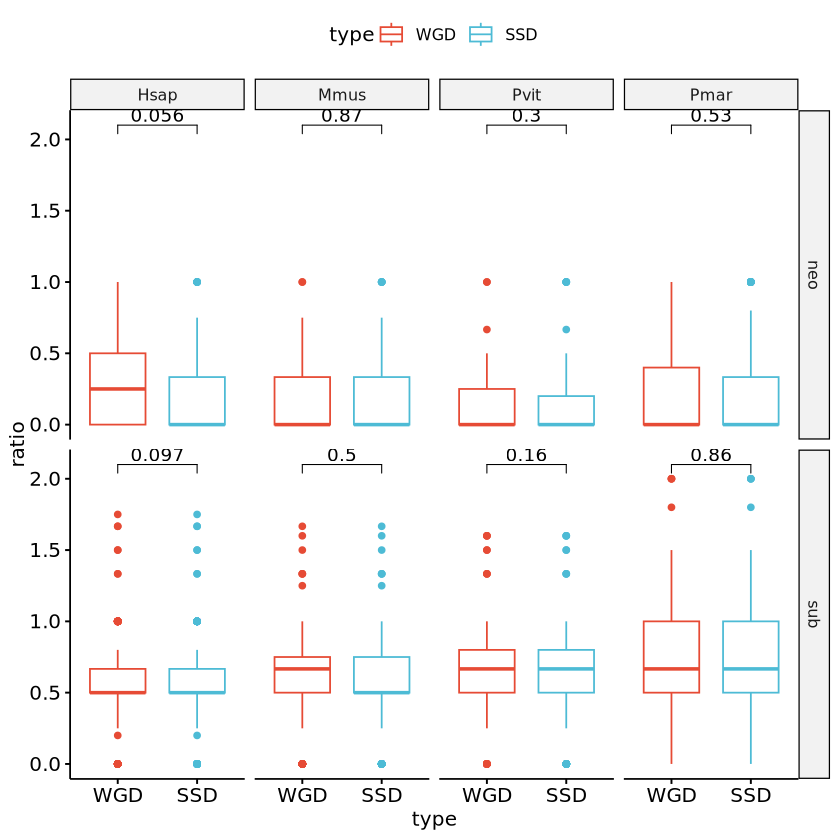

In [28]:
# not included in paper, pls ignore
my_comparisons <- list(c("WGD", "SSD"))
results %>% ggboxplot(x = "type", y = "ratio", color = "type", palette = "npg") + 
    stat_compare_means(comparisons = my_comparisons, method = "wilcox") + 
    facet_grid(vars(fun), vars(species))